In [24]:
import joblib
import pandas as pd
import requests
import urllib.parse
import json
import datetime
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import cross_val_score

In [2]:
ga_hits = pd.read_csv('data/ga_hits-001.csv')
ga_sessions = pd.read_csv('data/ga_sessions.csv') 

C:\Users\bogho\AppData\Local\Temp\ipykernel_4100\2570828873.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ga_sessions = pd.read_csv('data/ga_sessions.csv')


In [3]:
df_hits = ga_hits.copy()
df_sessions = ga_sessions.copy()

# 1

### Data preparation

In [4]:
#вставить столбец целевого действия
list_of_ca = ['sub_car_claim_click','sub_car_claim_submit_click', 'sub_open_dialog_click', 
               'sub_custom_question_submit_click', 'sub_call_number_click', 'sub_callback_submit_click',
               'sub_submit_success', 'sub_car_request_submit_click']

df_hits.loc[(df_hits.event_action.isin(list_of_ca)==True), 'cr'] = 1
df_hits.loc[(df_hits.event_action.isin(list_of_ca)==False), 'cr'] = 0

df_cr_groupped = df_hits.groupby(['session_id']).agg({'cr': max})
df_sessions = pd.merge(left=df_sessions, right=df_cr_groupped, on='session_id', how='inner')

C:\Users\bogho\AppData\Local\Temp\ipykernel_4100\2254412324.py:9: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_cr_groupped = df_hits.groupby(['session_id']).agg({'cr': max})


In [5]:
df_sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,cr
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0.0
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0.0
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0.0
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0.0
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0.0


In [6]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732266 entries, 0 to 1732265
Data columns (total 19 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   session_id                object 
 1   client_id                 object 
 2   visit_date                object 
 3   visit_time                object 
 4   visit_number              int64  
 5   utm_source                object 
 6   utm_medium                object 
 7   utm_campaign              object 
 8   utm_adcontent             object 
 9   utm_keyword               object 
 10  device_category           object 
 11  device_os                 object 
 12  device_brand              object 
 13  device_model              object 
 14  device_screen_resolution  object 
 15  device_browser            object 
 16  geo_country               object 
 17  geo_city                  object 
 18  cr                        float64
dtypes: float64(1), int64(1), object(17)
memory usage: 251.1+ MB


In [7]:
print(df_sessions.shape)
df_sessions.isna().sum()

(1732266, 19)


session_id                        0
client_id                         0
visit_date                        0
visit_time                        0
visit_number                      0
utm_source                       76
utm_medium                        0
utm_campaign                 195287
utm_adcontent                304137
utm_keyword                 1020752
device_category                   0
device_os                   1013964
device_brand                 347196
device_model                1717204
device_screen_resolution          0
device_browser                    0
geo_country                       0
geo_city                          0
cr                                0
dtype: int64

In [8]:
print('utm_source: ', df_sessions['utm_source'].value_counts(), '\n')
print('utm_campaign: ', df_sessions['utm_campaign'].value_counts(), '\n')
print('utm_adcontent: ', df_sessions['utm_adcontent'].value_counts(), '\n')

utm_source:  utm_source
ZpYIoDJMcFzVoPFsHGJL    552555
fDLlAcSmythWSCVMvqvL    277060
kjsLglQLzykiRbcDiGcD    245178
MvfHsxITijuriZxsqZqt    175831
BHcvLfOaCWvWTykYqHVe    110963
                         ...  
DWvtKQncdpXXfLBjBmGj         1
ZsHOHNXkbhgIDlKNiFMf         1
hYVrCkhCPSqKBhZYhWVq         1
OboZzsWwJIeGPLeiLGMq         1
sbJRYgVfvcnqKJNDDYIr         1
Name: count, Length: 280, dtype: int64 

utm_campaign:  utm_campaign
LTuZkdKfxRGVceoWkVyg    422992
LEoPHuyFvzoNfnzGgfcd    321286
FTjNLDyTrXaWYgZymFkV    234950
gecBYcKZCPMcVYdSSzKP    133247
XHNUiSKKGTEpSAlaVMFQ     23750
                         ...  
zXjuoqEaPElBnwpSHMpx         1
cqgnjDbqrtCipVvzhxqa         1
AdtHYglxfCpTpwZeTAuW         1
qPDTdivQVeflLjTYIJnG         1
cXxuwXPoQCvAXPHpFcZl         1
Name: count, Length: 406, dtype: int64 

utm_adcontent:  utm_adcontent
JNHcPlZPxEMWDnRiyoBf    935408
vCIpmpaGBnIQhyYNkXqp    179438
xhoenQgDQsgfEPYNPwKO    104381
PkybGvWbaqORmxjNunqZ     59038
LLfCasrxQzJIyuldcuWy     18138

In [9]:
# заполнение 'utm_source'
df_sessions['utm_source'].fillna(str(df_sessions['utm_source'].mode()), inplace=True)

# заполнение 'utm_campaign'
df_sessions['utm_campaign'].fillna(str(df_sessions['utm_campaign'].mode()), inplace=True)

# заполнение 'utm_adcontent'
df_sessions['utm_adcontent'].fillna(str(df_sessions['utm_adcontent'].mode()), inplace=True)

In [10]:
df_sessions.device_os.value_counts()

device_os
Android          425520
iOS              182597
Windows           81740
Macintosh         23415
Linux              4616
(not set)           309
Chrome OS            65
BlackBerry           24
Tizen                 7
Firefox OS            3
Nokia                 2
Samsung               2
Windows Phone         2
Name: count, dtype: int64

In [11]:
df_sessions.device_os.isna().sum()

1013964

In [12]:
# заполнение 'device_os' 
os_list = df_sessions.device_os.dropna().unique().tolist()
os_list.pop(1)
os_list.pop(5)
for elem in os_list:
    brands_with_os = df_sessions[df_sessions.device_os==elem].device_brand.dropna().unique().tolist()
    try:
        brands_with_os.remove('(not set)')
    except ValueError:
        pass
    df_sessions.loc[df_sessions['device_brand'].isin(brands_with_os), 'device_os'].fillna(str(elem), inplace=True)  
df_sessions['device_os'].fillna(str(df_sessions['device_os'].mode()), inplace=True)
df_sessions.loc[df_sessions['device_os']=='0    Android\nName: device_os, dtype: object', 'device_os'] = 'Android'


In [13]:
#органический трафик
organic_tr = ['organic', 'referal', '(none)']
df_sessions.loc[df_sessions.utm_medium.isin(organic_tr), 'organic_traffic'] = 1
df_sessions.organic_traffic = df_sessions.organic_traffic.fillna(0)

# реклама в соц сетях
social_media = ['QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 'ISrKoXQCxqqYvAZICvjs', 
                'IZEXUFLARCUMynmHNBGo', 'PlbkrSYoHuZBWfYjYnfw', 'gVRrcxiDQubJiljoTbGm']
df_sessions.loc[df_sessions.utm_source.isin(social_media), 'social_media_adv'] = 1
df_sessions.social_media_adv = df_sessions.social_media_adv.fillna(0)

#Россия ли страна
df_sessions.loc[df_sessions.geo_country == 'Russia', 'is_Russia'] = 1
df_sessions.is_Russia = df_sessions.is_Russia.fillna(0)

#Страны СНГ
#CIS = ['Azerbaijan', 'Armenia', 'Belarus', 'Kazakhstan', 'Kyrgyzstan', 'Moldova', 'Russia', 'Tajikistan', 'Uzbekistan']
#df_sessions.loc[df_sessions.geo_country.isin(CIS), 'is_CIS'] = 1
#df_sessions.is_CIS = df_sessions.is_CIS.fillna(0)

#Пост советские страны
#post_ussr_countries = ['Latvia', 'Lithuania', 'Estonia', 'Azerbaijan', 'Armenia', 'Belarus', 'Kazakhstan', 'Ukraine', 
                       #'Kyrgyzstan', 'Moldova', 'Russia', 'Tajikistan', 'Uzbekistan', 'Georgia', 'Turkmenistan']
#df_sessions.loc[df_sessions.geo_country.isin(post_ussr_countries), 'post_ussr_countries'] = 1
#df_sessions.post_ussr_countries = df_sessions.post_ussr_countries.fillna(0)


# Фича месяца
df_sessions['visit_date'] = pd.to_datetime(df_sessions['visit_date'])
df_sessions['visit_month'] = df_sessions.visit_date.dt.month

# Фича день
df_sessions['visit_day'] = df_sessions.visit_date.dt.day

# Фича день недели
df_sessions['visit_weekday'] = df_sessions['visit_date'].apply(lambda x: x.isoweekday())

# Фича час визита
df_sessions['visit_hour'] = pd.to_datetime(df_sessions['visit_time'], format="%H:%M:%S").dt.hour

#Фичи высоты и ширины экрана (2)
df_sessions.device_screen_resolution = df_sessions.device_screen_resolution.replace(['(not set)'],df_sessions.device_screen_resolution.mode())
df_sessions['device_screen_length'] = df_sessions.device_screen_resolution.apply(lambda x: int(x.split('x')[0]))
df_sessions['device_screen_width'] = df_sessions.device_screen_resolution.apply(lambda x: int(x.split('x')[1]))

In [14]:
#убрать столбец 'visit_number'
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    bounds = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return bounds

calculate_outliers(df_sessions['visit_number'])

(1.0, 1.0)

In [15]:
#долгота и широта
cities_list = df_sessions.geo_city.unique().tolist()
cities_dict = dict.fromkeys(cities_list)
for k, v in cities_dict.items():
    try:
        url = "https://nominatim.openstreetmap.org/?addressdetails=1&q=" + k + "&format=json&limit=1"
        response = requests.get(url).json()
        cities_dict[k] = [response[0]["lat"], response[0]["lon"]]
    except:
        country = df_sessions[df_sessions.geo_city == k].geo_country.mode()[0]
        url = "https://nominatim.openstreetmap.org/?addressdetails=1&q=" + country + "&format=json&limit=1"
        response = requests.get(url).json()
        cities_dict[k] = [response[0]["lat"], response[0]["lon"]]
df_sessions.loc[:, 'lat'] = df_sessions.geo_city.apply(lambda x: cities_dict[x][0] if x in cities_dict.keys() else NaN)
df_sessions.loc[:, 'lon'] = df_sessions.geo_city.apply(lambda x: cities_dict[x][1] if x in cities_dict.keys() else NaN)            
df_sessions.lon = df_sessions.lon.astype(float)
df_sessions.lat = df_sessions.lat.astype(float)

In [16]:
df_sessions.describe().apply(lambda s: s.apply('{0:.3f}'.format))

,visit_date,visit_number,cr,organic_traffic,social_media_adv,is_Russia,visit_month,visit_day,visit_weekday,visit_hour,device_screen_length,device_screen_width,lat,lon
count,1732266.000,1732266.000,1732266.000,1732266.000,1732266.000,1732266.000,1732266.000,1732266.000,1732266.000,1732266.000,1732266.000,1732266.000,1732266.000,1732266.000
mean,.3f,2.628,0.029,0.192,0.148,0.971,9.280,17.097,3.794,13.613,658.691,839.120,53.231,41.531
min,.3f,1.000,0.000,0.000,0.000,0.000,5.000,1.000,1.000,0.000,0.000,0.000,-46.412,-166.533
25%,.3f,1.000,0.000,0.000,0.000,1.000,7.000,10.000,2.000,10.000,360.000,760.000,55.615,37.606
50%,.3f,1.000,0.000,0.000,0.000,1.000,10.000,18.000,4.000,14.000,393.000,844.000,55.626,37.606
75%,.3f,1.000,0.000,0.000,0.000,1.000,11.000,25.000,5.000,19.000,428.000,896.000,56.131,39.688
max,.3f,564.000,1.000,1.000,1.000,1.000,12.000,31.000,7.000,23.000,5924.000,20000.000,69.600,177.506
std,nan,11.643,0.168,0.394,0.355,0.167,2.209,8.792,1.987,6.131,554.550,187.997,10.486,21.679


In [17]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732266 entries, 0 to 1732265
Data columns (total 30 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   session_id                object        
 1   client_id                 object        
 2   visit_date                datetime64[ns]
 3   visit_time                object        
 4   visit_number              int64         
 5   utm_source                object        
 6   utm_medium                object        
 7   utm_campaign              object        
 8   utm_adcontent             object        
 9   utm_keyword               object        
 10  device_category           object        
 11  device_os                 object        
 12  device_brand              object        
 13  device_model              object        
 14  device_screen_resolution  object        
 15  device_browser            object        
 16  geo_country               object        
 17  geo_city

In [18]:
df_sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,...,social_media_adv,is_Russia,visit_month,visit_day,visit_weekday,visit_hour,device_screen_length,device_screen_width,lat,lon
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,0.0,1.0,11,24,3,14,360,720,55.034639,59.529269
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,...,1.0,1.0,11,14,7,8,385,854,55.625578,37.606392
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,0.0,1.0,12,28,2,2,360,720,56.009097,92.872515
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,"0 LTuZkdKfxRGVceoWkVyg\nName: utm_campaign,...",NOBKLgtuvqYWkXQHeYWM,NaN,...,0.0,1.0,5,29,6,5,393,786,55.625578,37.606392
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,"0 LTuZkdKfxRGVceoWkVyg\nName: utm_campaign,...",0 JNHcPlZPxEMWDnRiyoBf\nName: utm_adcontent...,NaN,...,0.0,1.0,5,29,6,5,393,786,55.625578,37.606392


In [19]:
df_sessions = df_sessions.drop(['session_id', 'client_id', 'visit_date', 'visit_time', 'visit_number', 'utm_source', 
                                'utm_medium', 'utm_campaign', 'utm_adcontent','utm_keyword', 'device_brand', 'device_model', 
                                'device_screen_resolution', 'device_browser', 'geo_country', 'geo_city'], axis=1)
df_sessions

,device_category,device_os,cr,organic_traffic,social_media_adv,is_Russia,visit_month,visit_day,visit_weekday,visit_hour,device_screen_length,device_screen_width,lat,lon
0,mobile,Android,0.0,0.0,0.0,1.0,11,24,3,14,360,720,55.034639,59.529269
1,mobile,Android,0.0,0.0,1.0,1.0,11,14,7,8,385,854,55.625578,37.606392
2,mobile,Android,0.0,0.0,0.0,1.0,12,28,2,2,360,720,56.009097,92.872515
3,mobile,Android,0.0,0.0,0.0,1.0,5,29,6,5,393,786,55.625578,37.606392
4,mobile,Android,0.0,0.0,0.0,1.0,5,29,6,5,393,786,55.625578,37.606392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732261,desktop,Windows,0.0,0.0,0.0,1.0,12,22,3,10,1920,1080,55.625578,37.606392
1732262,mobile,Android,0.0,1.0,0.0,1.0,5,26,3,8,390,844,44.863258,43.440691
1732263,mobile,iOS,0.0,1.0,0.0,1.0,11,15,1,15,375,667,55.625578,37.606392
1732264,mobile,Android,0.0,0.0,0.0,1.0,11,29,1,15,393,851,55.159841,61.402555


In [20]:
numbers = df_sessions.select_dtypes(['int64', 'int32', 'float64']).columns.tolist()

In [21]:
numbers.pop(0)
numbers

['organic_traffic',
 'social_media_adv',
 'is_Russia',
 'visit_month',
 'visit_day',
 'visit_weekday',
 'visit_hour',
 'device_screen_length',
 'device_screen_width',
 'lat',
 'lon']

In [22]:
scaler = StandardScaler()
df_sessions.loc[:, numbers] = scaler.fit_transform(df_sessions.loc[:, numbers])
df_sessions

C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


,device_category,device_os,cr,organic_traffic,social_media_adv,is_Russia,visit_month,visit_day,visit_weekday,visit_hour,device_screen_length,device_screen_width,lat,lon
0,mobile,Android,0.0,-0.486989,-0.416693,0.172121,0.778628,0.785158,-0.399367,0.063092,-0.538619,-0.633628,0.172042,0.830231
1,mobile,Android,0.0,-0.486989,2.399848,0.172121,0.778628,-0.352268,1.613656,-0.915586,-0.493538,0.079150,0.228398,-0.181025
2,mobile,Android,0.0,-0.486989,-0.416693,0.172121,1.231346,1.240128,-0.902623,-1.894264,-0.538619,-0.633628,0.264974,2.368284
3,mobile,Android,0.0,-0.486989,-0.416693,0.172121,-1.937681,1.353871,1.110400,-1.404925,-0.479112,-0.282558,0.228398,-0.181025
4,mobile,Android,0.0,-0.486989,-0.416693,0.172121,-1.937681,1.353871,1.110400,-1.404925,-0.479112,-0.282558,0.228398,-0.181025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732261,desktop,Windows,0.0,-0.486989,-0.416693,0.172121,1.231346,0.557673,-0.399367,-0.589360,2.274473,1.281298,0.228398,-0.181025
1732262,mobile,Android,0.0,2.053432,-0.416693,0.172121,-1.937681,1.012643,-0.399367,-0.915586,-0.484521,0.025958,-0.797985,0.088099
1732263,mobile,iOS,0.0,2.053432,-0.416693,0.172121,0.778628,-0.238526,-1.405879,0.226205,-0.511570,-0.915547,0.228398,-0.181025
1732264,mobile,Android,0.0,-0.486989,-0.416693,0.172121,0.778628,1.353871,-1.405879,0.226205,-0.479112,0.063193,0.183982,0.916641


### Modeling

In [25]:
#OHE
ohe = OneHotEncoder(sparse=False)
ohe.fit(df_sessions[['device_category', 'device_os']])
ohe_X = ohe.transform(df_sessions[['device_category', 'device_os']])
df_sessions[ohe.get_feature_names()] = ohe_X

x = df_sessions.drop(['cr', 'device_category', 'device_os'], axis=1)
y = df_sessions['cr']

#LinearRegression
lr = LinearRegression()
lr.fit(x, y)
y_pred = lr.predict(x)
roc_auc = roc_auc_score(y, y_pred)
cross_val = cross_val_score(lr, x, y, cv=5)
print('LinearRegression: ', roc_auc,  'cross_val: ', cross_val)

#Logistic Regression
log = LogisticRegression()
log.fit(x, y)
y_pred = log.predict(x)
roc_auc = roc_auc_score(y, y_pred)
cross_val = cross_val_score(log, x, y, cv=5)
print('LogisticRegression: ', roc_auc,  'cross_val: ', cross_val)

#Decision Tree
tree = DecisionTreeClassifier(criterion='gini', max_features='sqrt', min_samples_split=10)
tree.fit(x, y)
y_pred = tree.predict(x)
roc_auc = roc_auc_score(y, y_pred)
cross_val = cross_val_score(tree, x, y, cv=5)
print('DecisionTreeClassifier,  roc_auc:', roc_auc, 'cross_val: ', cross_val)

#Random Forest
rfc = RandomForestClassifier()
rfc.fit(x, y)
y_pred = rfc.predict(x)
roc_auc = roc_auc_score(y, y_pred)
cross_val = cross_val_score(rfc, x, y, cv=5)
print('RandomForestClassifier,  roc_auc:', roc_auc, 'cross_val: ', cross_val)

C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future ve

LinearRegression:  0.6056868029150124 cross_val:  [ 4.35275133e-03  3.69956814e-03 -4.18671597e+14  4.13901832e-03
  3.68478538e-03]


C:\Users\bogho\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instea

LogisticRegression:  0.5 cross_val:  [0.9709543  0.9709571  0.97095421 0.97095421 0.97095421]


C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version

DecisionTreeClassifier,  roc_auc: 0.5470602346970316 cross_val:  [0.96701727 0.96697099 0.96694212 0.96722499 0.96709222]


C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version

RandomForestClassifier,  roc_auc: 0.7508574403729151 cross_val:  [0.9661831  0.96652071 0.9666506  0.96639082 0.96660153]


C:\Users\bogho\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bogho\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bogho\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


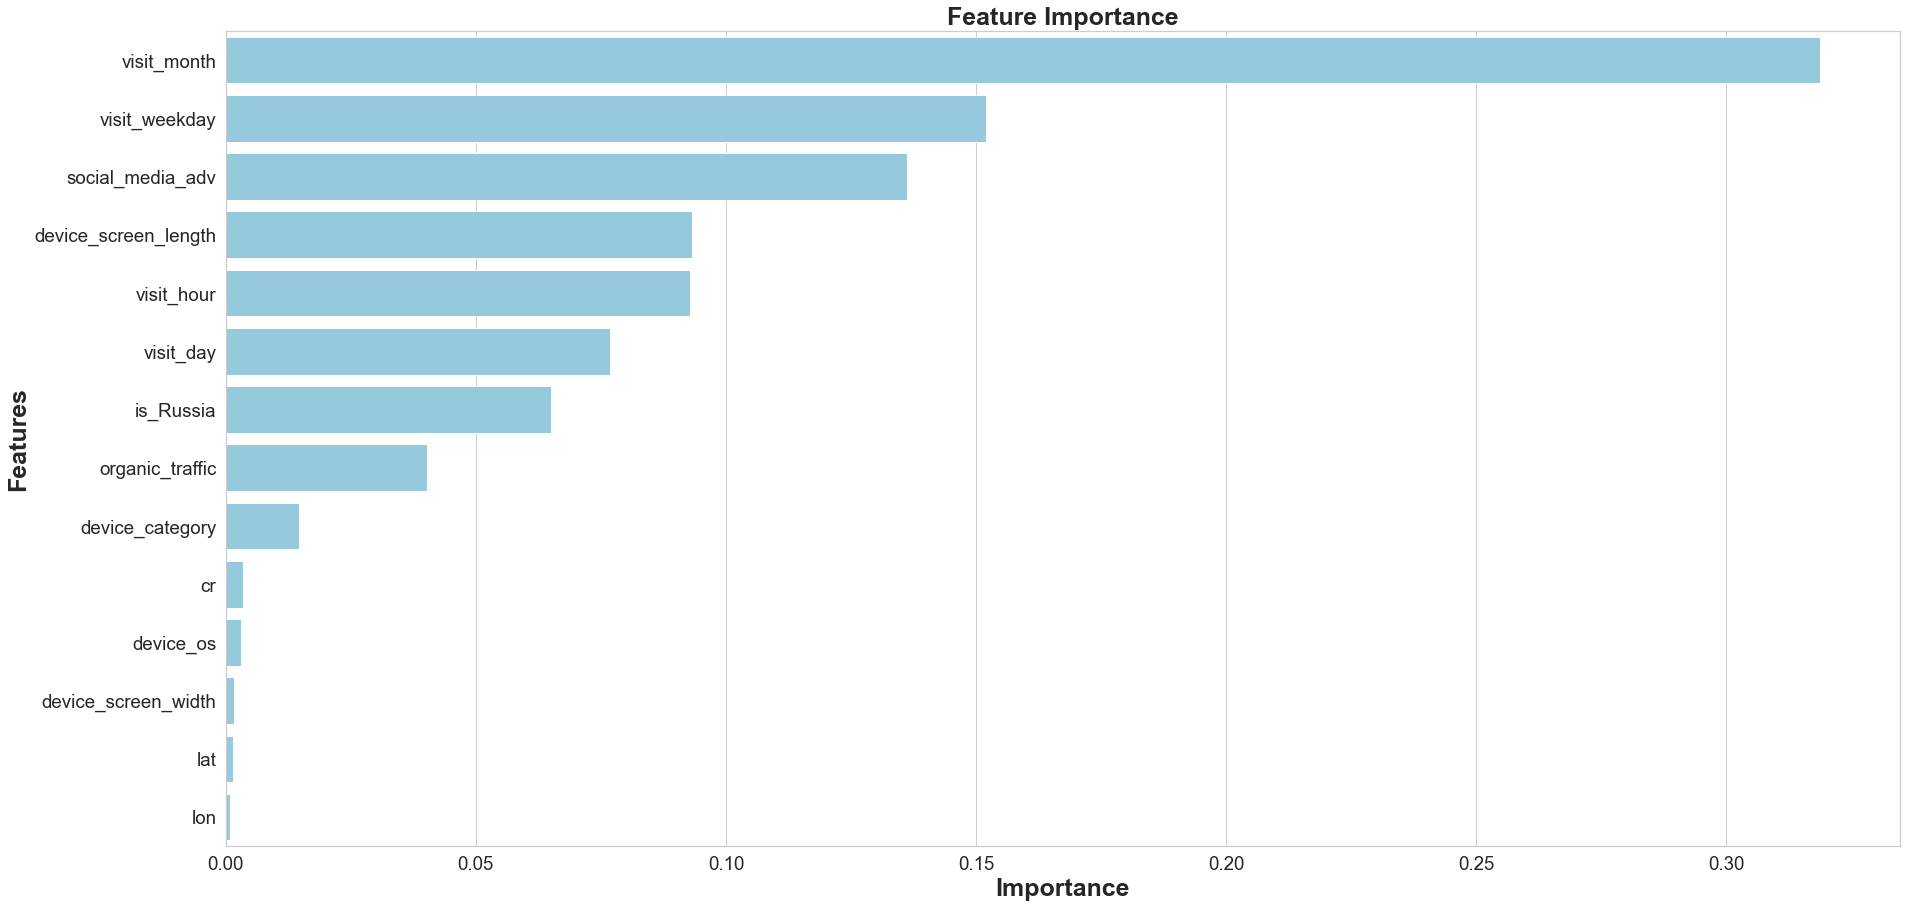

None

,Features,Gini-Importance
0,visit_month,0.318785
1,visit_weekday,0.151940
2,social_media_adv,0.136189
3,device_screen_length,0.093261
4,visit_hour,0.092734
5,visit_day,0.076881
6,is_Russia,0.065078
7,organic_traffic,0.040322
8,device_category,0.014613
9,cr,0.003401


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
feats = {}
for feature, importance in zip(df_sessions.columns, rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

In [27]:
df_sessions.columns

Index(['device_category', 'device_os', 'cr', 'organic_traffic',
       'social_media_adv', 'is_Russia', 'visit_month', 'visit_day',
       'visit_weekday', 'visit_hour', 'device_screen_length',
       'device_screen_width', 'lat', 'lon', 'x0_desktop', 'x0_mobile',
       'x0_tablet', 'x1_(not set)', 'x1_Android', 'x1_BlackBerry',
       'x1_Chrome OS', 'x1_Firefox OS', 'x1_Linux', 'x1_Macintosh', 'x1_Nokia',
       'x1_Samsung', 'x1_Tizen', 'x1_Windows', 'x1_Windows Phone', 'x1_iOS'],
      dtype='object')

In [28]:
list_to_drop = ['x1_(not set)', 'x1_Android', 'x1_BlackBerry', 'x1_Chrome OS', 'x1_Firefox OS', 'x1_Linux', 'x1_Macintosh', 'x1_Nokia',
                'x1_Samsung', 'x1_Tizen', 'x1_Windows', 'x1_Windows Phone', 'x1_iOS']

df_new = df_sessions.copy()
df_new = df_new.drop(list_to_drop, axis=1)
x = df_new.drop(['cr', 'device_category', 'device_os'], axis=1)
y = df_new['cr']

#LinearRegression
lr = LinearRegression()
lr.fit(x, y)
y_pred = lr.predict(x)
roc_auc = roc_auc_score(y, y_pred)
cross_val = cross_val_score(lr, x, y, cv=5)
print('LinearRegression: ', roc_auc,  'cross_val: ', cross_val)

#Logistic Regression
log = LogisticRegression()
log.fit(x, y)
y_pred = log.predict(x)
roc_auc = roc_auc_score(y, y_pred)
cross_val = cross_val_score(log, x, y, cv=5)
print('LogisticRegression: ', roc_auc,  'cross_val: ', cross_val)

#Decision Tree
tree = DecisionTreeClassifier()
tree.fit(x, y)
y_pred = tree.predict(x)
roc_auc = roc_auc_score(y, y_pred)
cross_val = cross_val_score(tree, x, y, cv=5)
print('DecisionTreeClassifier,  roc_auc:', roc_auc, 'cross_val: ', cross_val)

#Random Forest
rfc = RandomForestClassifier()
rfc.fit(x, y)
y_pred = rfc.predict(x)
roc_auc = roc_auc_score(y, y_pred)
cross_val = cross_val_score(rfc, x, y, cv=5)
print('RandomForestClassifier,  roc_auc:', roc_auc, 'cross_val: ', cross_val)

C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version

LinearRegression:  0.6044970027972909 cross_val:  [0.00437665 0.0037402  0.00347595 0.0041     0.00363565]


C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version

LogisticRegression:  0.5 cross_val:  [0.9709543  0.9709571  0.97095421 0.97095421 0.97095421]


C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version

DecisionTreeClassifier,  roc_auc: 0.743571695793018 cross_val:  [0.94991543 0.95062534 0.95039731 0.95006538 0.95044349]


C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\bogho\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version

RandomForestClassifier,  roc_auc: 0.7494082080323888 cross_val:  [0.96616867 0.96655535 0.96662751 0.9664803  0.96668235]
